# Capítulo 10

Uma das grandes vantagens de deep learning é a qualidade dos algoritmos e das implementações, que são capazes de rodar redes muito grandes, com milhões de parâmetros, em relativamente pouco tempo. Nesse notebook, vamos usar o pacote `keras`, que é uma camada de abstração acima do backend `tensorflow`, que também precisa ser instalado. Caso esses pacotes não estejam instalados, haverá um erro na hora de importar os pacotes. A solução é instalá-los via `conda install -c conda-forge tensorflow keras`.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# import seaborn as sns

import tensorflow.keras as tk
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
# from keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model

%matplotlib inline

## 10.9.1 Rede de uma camada

Em primeiro lugar, vamos voltar ao dataset `Hitters` e usar uma rede neural simples para fazer previsões. Já investigamos a performance de regressão linear e lasso nesses mesmos dados.

In [2]:
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True)
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

A interface do keras não é tão diferente de outros pacotes do scikit-learn. Primeiro, definimos os hiperparâmetros do modelo, depois, especificamos a arquitetura e, finalmente, rodamos `model.fit()`.

In [3]:
dropout_rate = 0.4
first_layout = 50
epochs = 150
batch_size = 32
activation = 'relu'
loss = 'mean_squared_error'
optimizer = 'adam'
metrics = ['mae']

In [4]:
model = Sequential()
model.add(Dropout(rate=dropout_rate, input_shape=(X_train.shape[1],)))
model.add(Dense(first_layout, activation=activation))
model.add(Dense(1))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Para ter uma visão completa dos parâmetros e da arquitetura, podemos usar `model.summary()`.

In [5]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 19)                0         
                                                                 
 dense (Dense)               (None, 50)                1000      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________
None


Finalmente, treinamos o modelos. Note a quantidade de informação que o `keras` disponibiliza ao longo do treinamento.

In [6]:
X_train.dtypes

AtBat          float64
Hits           float64
HmRun          float64
Runs           float64
RBI            float64
Walks          float64
Years          float64
CAtBat         float64
CHits          float64
CHmRun         float64
CRuns          float64
CRBI           float64
CWalks         float64
PutOuts        float64
Assists        float64
Errors         float64
League_A          bool
Division_E        bool
NewLeague_A       bool
dtype: object

In [7]:
model.fit(X_train.astype('float32'), y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/150


2024-01-27 11:57:07.528157: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 3ms/step - loss: 363587.9375 - mae: 435.0867
Epoch 2/150
3/3 [==============================] - 0s 2ms/step - loss: 350568.3125 - mae: 411.7088
Epoch 3/150
3/3 [==============================] - 0s 2ms/step - loss: 323797.8438 - mae: 390.4350
Epoch 4/150
3/3 [==============================] - 0s 1ms/step - loss: 348720.6875 - mae: 391.7174
Epoch 5/150
3/3 [==============================] - 0s 2ms/step - loss: 238702.2188 - mae: 333.7416
Epoch 6/150
3/3 [==============================] - 0s 2ms/step - loss: 279751.4688 - mae: 360.6497
Epoch 7/150
3/3 [==============================] - 0s 1ms/step - loss: 201375.3281 - mae: 305.6625
Epoch 8/150
3/3 [==============================] - 0s 2ms/step - loss: 218223.5469 - mae: 298.7906
Epoch 9/150
3/3 [==============================] - 0s 1ms/step - loss: 218300.0469 - mae: 314.8358
Epoch 10/150
3/3 [==============================] - 0s 1ms/step - loss: 216647.7969 - mae: 311.7784
Epoch 11/150
3/3 [===

Por último, avaliamos o modelo no conjunto de teste.

In [8]:
mse_test, mae_test = model.evaluate(X_test.astype('float32'), y_test)
print(f"Test mse: {mse_test}, Test mae: {mae_test}")

6/6 [==============================] - 0s 914us/step - loss: 128072.3828 - mae: 224.1195
Test mse: 128072.3828125, Test mae: 224.11953735351562


## 10.9.2 Redes de várias camadas

O exemplo anterior usou uma rede relativamente simples. Agora, vamos começar a olhar para problemas mais complicados onde os métodos anteriores não trariam bons resultados. Em primeiro lugar, avmos usar uma base de dados nova, chamada MNIST. O próprio keras é capaz de baixar os dados localmente.

In [9]:
(X_train, y_train), (X_test, y_test) = tk.datasets.mnist.load_data()

Vamos analisar a estrutura dos nossos dados. Em primeiro lugar, estamos falando de imagens $28 \times 28$. Há dez possíveis classes a serem previstas (uma para cada dígito 0-9).

In [10]:
print(X_train.shape)
print(np.max(X_train))

print(y_train.shape)
print(np.unique(y_train))

(60000, 28, 28)
255
(60000,)
[0 1 2 3 4 5 6 7 8 9]


Quão difícil parece ser classificar esses dígitos? Podemos visualizar alguns exemplos. 

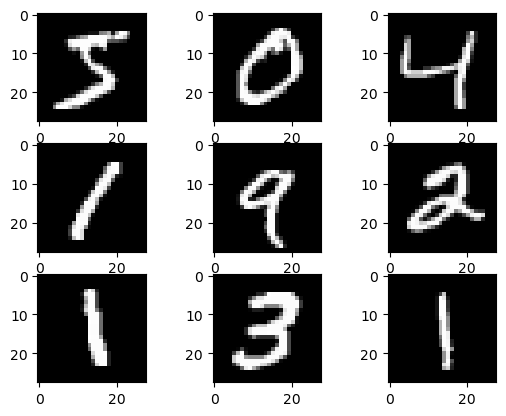

In [11]:
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

Cada imagem é uma matriz $28 \times 28$, mas para usar como input num algoritmo de machine learning, vamos transformar a matriz num vetor, basicamente empilhando cada linha. Também queremos transformar a intensidade do pixel (entre 0 e 255) para um número entre 0 e 1, como se estivéssemos normalizando as features. Finalmente, vamos especificar que as entradas nos vetores `y` são categóricos.

In [12]:
X_train = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

A rede que vamos considerar é apenas uma sequência de camadas densas, com dropout.

In [13]:
model = Sequential()
model.add(Dense(256, input_dim = 28 * 28, activation= 'relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(10, activation = 'softmax'))

Há várias opções de otimizadores e perdas. Aqui, faz sentido usar a perda multinomial (chamada de `categorical_crossentropy`) para treino, mas avaliar o sucesso das previsões num conjunto de validação via acurácia. Sobre os otimizadores, é comum usar ou `rmsprop` ou `adam`, que são baseados em descida de gradiente com momento. 

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {acc}')

Epoch 1/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3295 - accuracy: 0.9019 - val_loss: 0.1420 - val_accuracy: 0.9583
Epoch 2/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1941 - accuracy: 0.9477 - val_loss: 0.1147 - val_accuracy: 0.9691
Epoch 3/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1724 - accuracy: 0.9560 - val_loss: 0.1122 - val_accuracy: 0.9735
Epoch 4/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1628 - accuracy: 0.9615 - val_loss: 0.1201 - val_accuracy: 0.9730
Epoch 5/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1559 - accuracy: 0.9649 - val_loss: 0.1180 - val_accuracy: 0.9752
Epoch 6/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1589 - accuracy: 0.9656 - val_loss: 0.1267 - val_accuracy: 0.9774
Epoch 7/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1551 - accuracy: 0.9678 - val_loss: 0.1317 - val_accuracy:

Note que salvamos o fit do modelo no objeto `history_model`. Daí podemos recuperar o comportamento da métrica ao longo do treinamento.

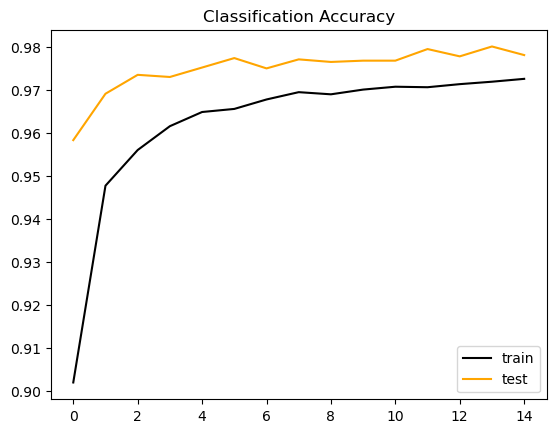

In [15]:
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

Curiosamente, a perda de teste está consistentemente acima da perda de treino. Isso sugere que um modelo mais flexível poderia tentar melhorar a perda de teste (i.e., ainda não estamos correndo risco de overfitting).

## 10.9.3 Convolutional Neural Networks

Existem arquiteturas que costumam funcionar melhor para certos tipos de dados. Por exemplo, redes convolucionais geralmente performam muito bem em imagens. Vamos usar outro conjunto de imagens nessa subseção, chamado CIFAR100, e investigar o impacto da rede convolucional nesses dados.

In [16]:
(X_train, y_train), (X_test, y_test) = tk.datasets.cifar100.load_data()

O dataset CIFAR100, ao contrário do MNIST, possui três canais de cores. Por isso, `X_train.shape` tem uma dimensão a mais. Além disso, ao invés de tentar prever 10 classes (de dígitos, no MNIST) há 100 categorias a serem previstas no CIFAR100 (e.g., airplane, hamster, orchids, skyscraper, etc.)

In [17]:
print(X_train.shape)
print(np.max(X_train))

print(y_train.shape)
print(np.unique(y_train))

(50000, 32, 32, 3)
255
(50000, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


As imagens podem ser facilmente visualizadas.

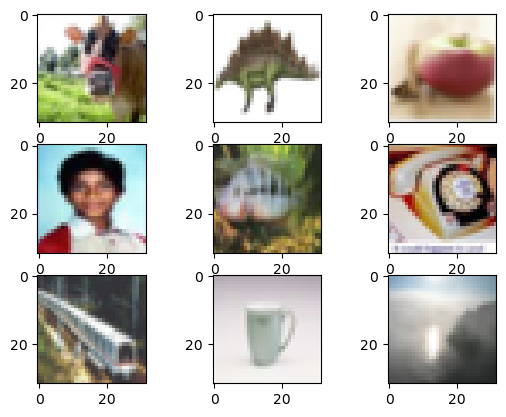

In [18]:
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

Para preparar as imagens para as redes neurais, vamos seguir o mesmo procedimento de antes: normalizar as imagens e transformar as previsões em categorias.

In [19]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

O modelo será composto por 3 blocos (com um camada convolucional e pooling cada), seguindo a arquitetura VGG.

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(100, activation='softmax'))

Agora, podemos treinar o modelo. Note que, pelo grande número de parâmetros, os modelos abaixo podem tomar muito tempo (e.g., alguns minutos) para serem treinados num computador pessoal.

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)
_, acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {acc}')

Epoch 1/5
391/391 [==============================] - 106s 270ms/step - loss: 4.0056 - accuracy: 0.0953 - val_loss: 3.4774 - val_accuracy: 0.1838
Epoch 2/5
391/391 [==============================] - 104s 265ms/step - loss: 3.2101 - accuracy: 0.2289 - val_loss: 2.9550 - val_accuracy: 0.2815
Epoch 3/5
391/391 [==============================] - 106s 271ms/step - loss: 2.7232 - accuracy: 0.3194 - val_loss: 2.8334 - val_accuracy: 0.3064
Epoch 4/5
391/391 [==============================] - 113s 290ms/step - loss: 2.3665 - accuracy: 0.3952 - val_loss: 2.4850 - val_accuracy: 0.3747
Epoch 5/5
313/313 [==============================] - 8s 26ms/step - loss: 2.4234 - accuracy: 0.3896
Test accuracy: 0.38960000872612


Como antes, vamos investigar o comportamento das perdas de treino e teste ao longo das épocas.

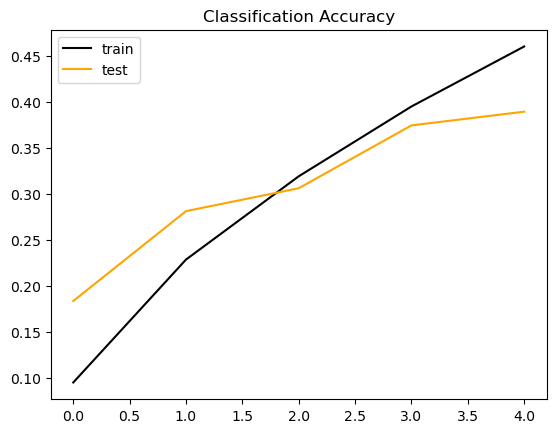

In [22]:
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

Como antes, é fácil adaptar a arquitetura do modelo. Por exemplo, podemos adicionar algumas camadas de dropout.

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)
_, acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {acc}')

Epoch 1/5
391/391 [==============================] - 116s 294ms/step - loss: 4.3102 - accuracy: 0.0496 - val_loss: 3.8771 - val_accuracy: 0.1177
Epoch 2/5
391/391 [==============================] - 113s 290ms/step - loss: 3.6820 - accuracy: 0.1407 - val_loss: 3.3711 - val_accuracy: 0.1969
Epoch 3/5
391/391 [==============================] - 113s 290ms/step - loss: 3.3124 - accuracy: 0.2051 - val_loss: 3.1104 - val_accuracy: 0.2498
Epoch 4/5
391/391 [==============================] - 117s 300ms/step - loss: 3.0538 - accuracy: 0.2516 - val_loss: 2.8518 - val_accuracy: 0.2974
Epoch 5/5
313/313 [==============================] - 8s 25ms/step - loss: 2.7622 - accuracy: 0.3207
Test accuracy: 0.3206999897956848


Agora, a acurácia de teste caiu um pouco de 39% para 32%. Dropout ajuda em casos de overfit, mas o gráfico das perdas parecia indicar que a acurácia de teste ainda estava melhorando. Para dropout começar a ajudar, teríamos que aumentar o número de épocas para a faixa de milhares, o que é comum em deep learning. Com tantas épocas, é de se esperar que overfitting fosse começar a aparecer, e aí camadas de dropout seriam úteis.

Como vimos, existem outras maneiras de evitar overfitting. Uma possibilidade é weight decay ou learning rate do otimizador, outra é regularizar os coeficientes da rede:

`model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))`

Essas opções são hiperparâmetros do modelo e, portanto, fáceis de serem adaptadas. Outras opções são early stopping e data augmentation. 

## 10.9.4 Using Pretrained CNN Models

Uma enorme vantagem de redes neurais é que várias arquiteturas bem-sucedidas em tarefas importantes são disponibilizadas já pre-treinadas. Considerando que treinar essas redes pode tomar muitos e muitos dias, essa conveniência é fantástica para rapidamente podermos gerar boas previsões. Vamos baixar uma arquitetura famosa, a VGG16.

In [24]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Este modelo tem quase 140 milhões de parâmetros!

Para fazer uma previsão com esse modelo, vamos abrir uma imagem de um cachorro e ver se a rede consegue classificá-la corretamente. É possível usar qualquer outra imagem também.

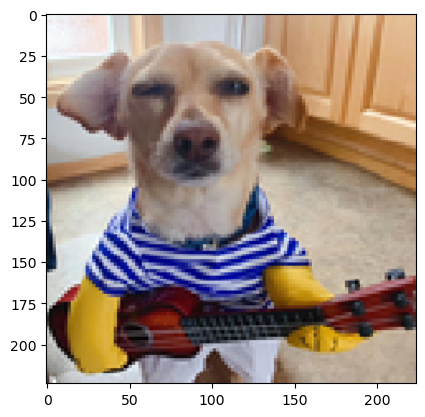

In [25]:
image = load_img('../data/dog_test.jpg', target_size=(224, 224))
plt.imshow(image)
plt.show()

É preciso preprocessar a imagem para que ela sirva de input para a rede. Em primeiro lugar, a imagem precisa virar um vetor com as dimensões adequadas, e em segundo vamos querer normalizar a imagem.

In [26]:
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

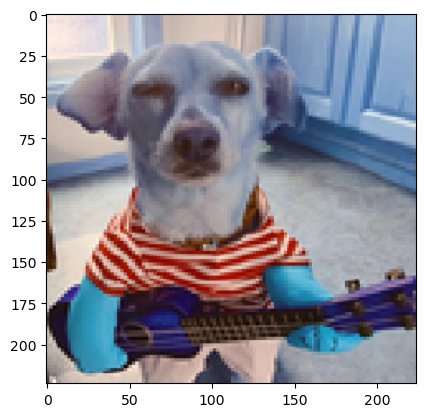

In [27]:
plt.imshow(array_to_img(image[0]))
plt.show()

Para gerar previsões, basta usar o mesmo formato `model.predict(image)` de antes.

In [28]:
yhat = model.predict(image)
label = decode_predictions(yhat)
print(label)

1/1 [==============================] - 0s 340ms/step
[[('n02099712', 'Labrador_retriever', 0.2146041), ('n04597913', 'wooden_spoon', 0.062973745), ('n02085620', 'Chihuahua', 0.043485563), ('n03481172', 'hammer', 0.04137766), ('n02093256', 'Staffordshire_bullterrier', 0.039868344)]]


Ou seja, o modelo classifica a imagem como um "labrador retriever" com score de ~20%. A segunda opção é "wooden spoon", mas com um score bem mais baixo (apesar da terceira opção, "chihuahua", ser mais razoável do que a segunda).

Há outras vantagens em ter modelos pré-treinados, além de simplesmente poder fazer previsões com modelos poderosos sem ter que treiná-los. Uma outra vantagem é usá-los para destilar features a partir das imagens, e usar isso como base para outros modelos de machine learning. Abaixo, vamos comprimir a imagem acima, de tamanho $224 \times 224 \times 3 = 150528$ num vetor de dimensão $4096$. Isso é feito salvando o output da imagem logo antes de ser enviado à última camada da rede, que é apenas uma regressão multinomial.

In [29]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = model.predict(image)
print(features.shape)

1/1 [==============================] - 0s 352ms/step
(1, 4096)


Ao contrário da imagem, as features abaixo não têm muito significado para nós mas podem ser aproveitadas por outros métodos de machine learning para gerar previsões.

In [30]:
features

array([[0.7345303, 1.3117371, 1.3220532, ..., 0.       , 0.878445 ,
        0.       ]], dtype=float32)

## 10.9.5 Classificação de documentos do IMDb

Considere agora um problema de classificação de críticas no site de filmes IMDb. De cada review, nós vamos baixar apenas as 10.000 palavras mais comuns (para evitar que os reviews sejam cheios de "o", "as").

In [31]:
start_char = 1
oov_char = 2
index_from = 3
(X_train, y_train), (X_test, y_test) = tk.datasets.imdb.load_data(num_words=10000, index_from = index_from)

Há 2500 entradas em `X_train`, cada uma com tamanho variável, em que cada elemento do vetor indica o número referente à palavra naquela posição.

In [32]:
print(f"Words in first review: {len(X_train[0])}")
print(f"Words in second review: {len(X_train[1])}")

Words in first review: 218
Words in second review: 189


Para conseguir ler uma crítica, vamos baixar o dicionário que indica qual é a palavra referente a qual número. 

In [33]:
word_index = tk.datasets.imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"

Acima, "[START]" é um código especial para o começo do review, e "[OOV]" indica uma palavra fora do vocabulário de 10.000 palavras. Com isso, conseguimos ler a primeira crítica.

In [34]:
" ".join(inverted_word_index[i] for i in X_train[0])

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [OOV] is an amazing actor and now the same being director [OOV] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [OOV] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [OOV] to the two little boy's that played the [OOV] of norman and paul they were just brilliant children are often left out of the [OOV] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Para cada review, a entrada em `y` correspondente indica se a crítica é positiva (`y=1`) ou negativa (`y=0`).

In [35]:
print(y_train.shape)
print(np.unique(y_train))
print(f"A primeira crítica é {'positiva' if y_train[0] == 1 else 'negativa'}.")
print(f"A segunda crítica é {'positiva' if y_train[1] == 1 else 'negativa'}.")

(25000,)
[0 1]
A primeira crítica é positiva.
A segunda crítica é negativa.


Vamos tentar entender as críticas de maneira agregada. Por exemplo, quão longas elas são?

Review length: 
Mean: 238.71364 words, std dev: 176.49367364852034


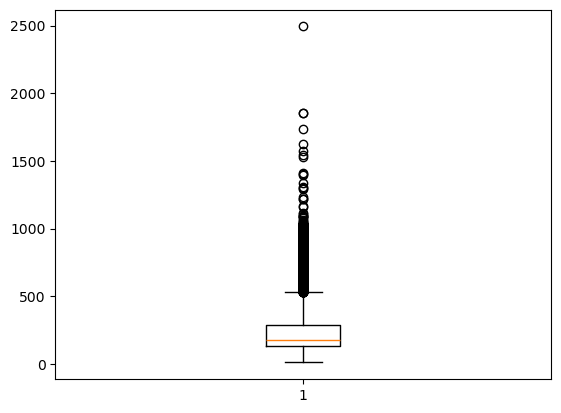

In [36]:
print("Review length: ")
result = [len(x) for x in X_train]
print(f"Mean: {np.mean(result)} words, std dev: {np.std(result)}")
plt.boxplot(result)
plt.show()

Para reduzir o tempo de treino, vamos nos ater às primeiras 500 palavras de cada crítica. Note pelo gráfico anterior que isso não afeta praticamente 75% das críticas.

In [37]:
max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

Um problema da construção acima é que a numeração dada às palavras não quer dizer muita coisa. Por exemplo, a palavra de número 60 não necessariamente é mais parecida com a palavra 61 do que a palavra 1032.

In [38]:
print(inverted_word_index[60])
print(inverted_word_index[61])
print(inverted_word_index[1032])

even
my
odd


Por isso, ao construir nossa arquitetura, vamos primeiro adicionar uma camada de embedding, que transforma cada palavra em um vetor, de tal maneira que a distância entre os vetores mede, em algum sentido, a similaridade das palavras.

In [39]:
model = Sequential()
model.add(Embedding(10000, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten_2 (Flatten)         (None, 16000)             0         
                                                                 
 dense_9 (Dense)             (None, 16)                256016    
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 576,305
Trainable params: 576,305
Non-trainable params: 0
_________________________________________________________________
None


Como o modelo pode ser lento para treinar, vamos rodar apenas 5 épocas.

In [40]:
history_model = model.fit(X_train, y_train, epochs=5,
                          batch_size=512, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {acc}')

Epoch 1/5
49/49 [==============================] - 2s 28ms/step - loss: 0.6397 - accuracy: 0.6087 - val_loss: 0.4845 - val_accuracy: 0.7843
Epoch 2/5
49/49 [==============================] - 2s 33ms/step - loss: 0.3533 - accuracy: 0.8556 - val_loss: 0.3670 - val_accuracy: 0.8331
Epoch 3/5
49/49 [==============================] - 2s 33ms/step - loss: 0.2291 - accuracy: 0.9116 - val_loss: 0.3532 - val_accuracy: 0.8450
Epoch 4/5
49/49 [==============================] - 2s 33ms/step - loss: 0.1657 - accuracy: 0.9398 - val_loss: 0.2920 - val_accuracy: 0.8776
Epoch 5/5
782/782 [==============================] - 1s 854us/step - loss: 0.3227 - accuracy: 0.8671
Test accuracy: 0.8670799732208252


E, como antes, podemos medir a nossa acurácia em prever se a crítica é positiva ou negativa.

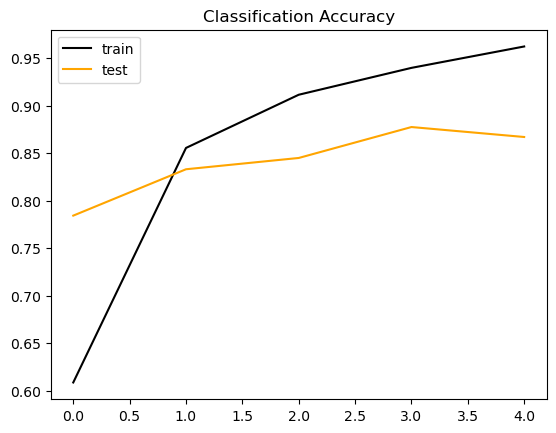

In [41]:
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

Parece estarmos conseguindo um bom modelo com apenas 5 épocas: nossa previsão de teste é de 86%! Por outro lado, há evidências de que na quinta época já há algum overfitting, então poderíamos adicionar algumas técnicas de regularização, como dropout.

## 10.9.6 Redes neurais recorrentes

No exemplo anterior, usamos apenas camadas densas. Como a ordem das palavras importam, é interessante ver se redes neurais recorrentes conseguem superar a performance que atingimos. Vamos usar o mesmo setup da última subseção, mas usaremos uma camada LSTM ao invés de camadas densas.

In [42]:
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = tk.datasets.imdb.load_data(num_words=vocabulary_size)

max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


2024-01-27 12:17:17.352259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 12:17:17.352963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 12:17:17.353919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

O modelo tem 213 mil parâmetros e, pelo tamanho do input, é relativamente lento de se rodar (toma 1.5 minuto por época). Vamos portanto rodá-lo por apenas 5 épocas.

In [43]:
history_model = model.fit(X_train, y_train, epochs=5,
                          batch_size=512, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {acc}')

Epoch 1/5


2024-01-27 12:17:17.533467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 12:17:17.534521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 12:17:17.535368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6649

2024-01-27 12:18:32.512286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-27 12:18:32.513073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-27 12:18:32.513989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - 106s 2s/step - loss: 0.6650 - accuracy: 0.6649 - val_loss: 0.5378 - val_accuracy: 0.7893
Epoch 2/5
49/49 [==============================] - 115s 2s/step - loss: 0.4639 - accuracy: 0.8036 - val_loss: 0.5329 - val_accuracy: 0.7293
Epoch 3/5
49/49 [==============================] - 105s 2s/step - loss: 0.3703 - accuracy: 0.8442 - val_loss: 0.4248 - val_accuracy: 0.8143
Epoch 4/5
49/49 [==============================] - 108s 2s/step - loss: 0.3496 - accuracy: 0.8539 - val_loss: 0.3262 - val_accuracy: 0.8690
Epoch 5/5
782/782 [==============================] - 69s 88ms/step - loss: 0.3722 - accuracy: 0.8367
Test accuracy: 0.8367199897766113


De fato, atingimos uma acurácia levemente melhor do que antes. Se olharmos para a evolução das perdas, parece que o overfitting foi atenuado também.

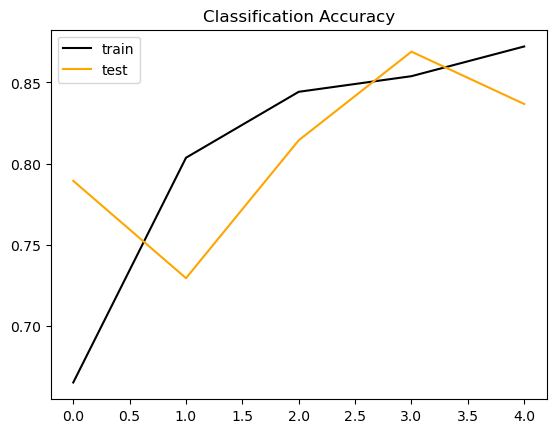

In [44]:
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

De modo geral, os pacotes modernos de deep learning tornam fácil a tarefa de treinar modelos de milhares ou milhões de parâmetros, e a existência de arquiteturas de alta performance para tipos de dados diferentes, além de modelos pré-treinados, justificam a imensa popularidade desse método.